In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torchvision.models import resnet18, resnet34, vgg16
from torch.utils.data import DataLoader, random_split
import time
import copy
import seaborn as sns
from sklearn.metrics import confusion_matrix

# For reproducibility
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Check GPU
if torch.cuda.is_available():
    my_device = "cuda"
else:
    my_device = "cpu"
print(f"Using: {my_device}")

Using: cuda


In [2]:
# Data preparation steps
def prepare_data():
    # Data transforms
    my_train_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),  # Flip images for more data
        transforms.RandomCrop(32, padding=4),  # Crop images
        transforms.ToTensor(),  # Convert to tensor
        # Normalize with CIFAR-10 mean and std
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])

    my_test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])

    # Load dataset
    complete_train_data = torchvision.datasets.CIFAR10(
        root='./data', 
        train=True,
        download=True, 
        transform=my_train_transform
    )

    # Split into train and validation
    train_data_size = int(0.9 * len(complete_train_data))
    val_data_size = len(complete_train_data) - train_data_size
    train_data, val_data = random_split(complete_train_data, [train_data_size, val_data_size])

    test_data = torchvision.datasets.CIFAR10(
        root='./data', 
        train=False,
        download=True, 
        transform=my_test_transform
    )

    # Create data loaders
    my_train_loader = DataLoader(train_data, batch_size=128, shuffle=True, num_workers=2)
    my_val_loader = DataLoader(val_data, batch_size=128, shuffle=False, num_workers=2)
    my_test_loader = DataLoader(test_data, batch_size=128, shuffle=False, num_workers=2)

    return my_train_loader, my_val_loader, my_test_loader

In [3]:
# Simple ResNet18
class MyResNet18(nn.Module):
    def __init__(self):
        super(MyResNet18, self).__init__()
        # Load pretrained model
        self.base_model = resnet18(pretrained=True)
        # Change first layer for CIFAR-10
        self.base_model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.base_model.maxpool = nn.Identity()  # Remove maxpool
        # Change last layer for 10 classes
        self.base_model.fc = nn.Linear(self.base_model.fc.in_features, 10)

    def forward(self, x):
        return self.base_model(x)

# Simple ResNet34
class MyResNet34(nn.Module):
    def __init__(self):
        super(MyResNet34, self).__init__()
        self.base_model = resnet34(pretrained=True)
        self.base_model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.base_model.maxpool = nn.Identity()
        self.base_model.fc = nn.Linear(self.base_model.fc.in_features, 10)

    def forward(self, x):
        return self.base_model(x)

# Simple VGG16
class MyVGG16(nn.Module):
    def __init__(self):
        super(MyVGG16, self).__init__()
        self.base_model = vgg16(pretrained=True)
        
        # Get features part of VGG (convolutional layers)
        self.features = self.base_model.features
        
        # Calculate correct input size for classifier
        # For 32x32 input, after VGG conv layers, we get 512 channels and 1x1 spatial dimensions
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        
        # New classifier for CIFAR-10
        self.classifier = nn.Sequential(
            nn.Linear(512, 512),  # Reduced size compared to original VGG
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(512, 10),  # 10 classes for CIFAR-10
        )

    def forward(self, x):
        # Pass through convolutional layers
        x = self.features(x)
        # Global average pooling
        x = self.avgpool(x)
        # Flatten
        x = torch.flatten(x, 1)
        # Pass through classifier
        x = self.classifier(x)
        return x

In [4]:
# Function to show some training images
def show_train_images(train_loader):
    # Get some random training images
    data_iter = iter(train_loader)
    images, labels = next(data_iter)
    
    # CIFAR10 classes
    classes = ['plane', 'car', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']
    
    # Show images
    plt.figure(figsize=(10, 5))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        # Convert tensor to image
        img = images[i].numpy().transpose((1, 2, 0))
        # Un-normalize
        mean = np.array([0.4914, 0.4822, 0.4465])
        std = np.array([0.2023, 0.1994, 0.2010])
        img = std * img + mean
        img = np.clip(img, 0, 1)
        plt.imshow(img)
        plt.title(classes[labels[i]])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Function to train models
def train_my_model(model, train_loader, val_loader, num_epochs=15):
    model = model.to(my_device)
    
    # Loss function and optimizer
    loss_function = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
    
    # Save best model
    best_model = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    # Lists to store metrics
    all_train_losses = []
    all_val_losses = []
    all_train_accs = []
    all_val_accs = []
    all_learning_rates = []
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 20)
        
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        for images, labels in train_loader:
            images = images.to(my_device)
            labels = labels.to(my_device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            train_total += labels.size(0)
            train_correct += predicted.eq(labels).sum().item()
        
        train_accuracy = 100 * train_correct / train_total
        train_loss = train_loss / len(train_loader)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(my_device)
                labels = labels.to(my_device)
                
                outputs = model(images)
                loss = loss_function(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()
        
        val_accuracy = 100 * val_correct / val_total
        val_loss = val_loss / len(val_loader)
        
        # Save metrics
        all_train_losses.append(train_loss)
        all_val_losses.append(val_loss)
        all_train_accs.append(train_accuracy)
        all_val_accs.append(val_accuracy)
        all_learning_rates.append(optimizer.param_groups[0]['lr'])
        
        print(f'Train Loss: {train_loss:.4f} Train Acc: {train_accuracy:.2f}%')
        print(f'Val Loss: {val_loss:.4f} Val Acc: {val_accuracy:.2f}%')
        
        # Save best model
        if val_accuracy > best_acc:
            best_acc = val_accuracy
            best_model = copy.deepcopy(model.state_dict())
        
        scheduler.step()
    
    # Load best model
    model.load_state_dict(best_model)
    
    return model, all_train_losses, all_val_losses, all_train_accs, all_val_accs, all_learning_rates

In [5]:
# Function to make confusion matrix
def plot_confusion_matrix(model, test_loader, class_names):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(my_device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())
    
    # Create confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Function to plot learning rate changes
def plot_learning_rate(learning_rates, title):
    plt.figure(figsize=(10, 5))
    plt.plot(learning_rates, 'bo-')
    plt.title(f'{title} - Learning Rate Schedule')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.grid(True)
    plt.show()

# Function to show all training plots
def show_training_plots(train_losses, val_losses, train_accs, val_accs, title):
    plt.figure(figsize=(15, 5))
    
    # Plot losses
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss', color='blue')
    plt.plot(val_losses, label='Val Loss', color='red')
    plt.title(f'{title} - Loss over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Plot accuracies
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train Acc', color='blue')
    plt.plot(val_accs, label='Val Acc', color='red')
    plt.title(f'{title} - Accuracy over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# Function to plot feature maps
def plot_feature_maps(model, test_loader):
    # Get one batch of test images
    dataiter = iter(test_loader)
    images, _ = next(dataiter)
    
    # Get one image
    img = images[0:1].to(my_device)
    
    # Set model to eval mode
    model.eval()
    
    # For ResNet models
    if isinstance(model, (MyResNet18, MyResNet34)):
        # Get feature maps from first conv layer
        activation = {}
        def get_activation(name):
            def hook(model, input, output):
                activation[name] = output.detach()
            return hook
        
        model.base_model.conv1.register_forward_hook(get_activation('conv1'))
        
        # Forward pass
        with torch.no_grad():
            output = model(img)
        
        # Get feature maps
        feature_maps = activation['conv1'].squeeze(0)
        
        # Plot first 16 feature maps
        plt.figure(figsize=(20, 10))
        for idx in range(min(16, feature_maps.shape[0])):
            plt.subplot(4, 4, idx+1)
            plt.imshow(feature_maps[idx].cpu(), cmap='viridis')
            plt.axis('off')
        plt.suptitle('First Conv Layer Feature Maps')
        plt.show()

Files already downloaded and verified
Files already downloaded and verified


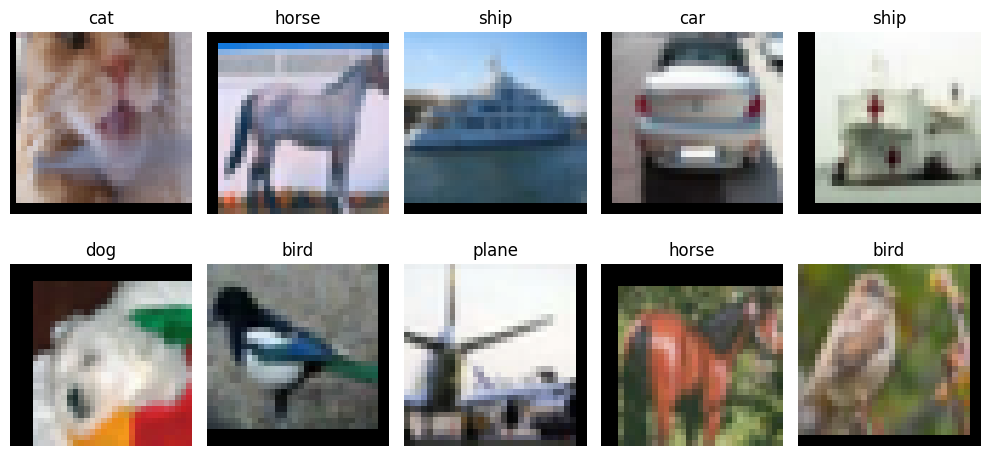

/root/miniconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/root/miniconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the mo


Training ResNet18...
Epoch 1/15
--------------------
Train Loss: 0.7367 Train Acc: 74.50%
Val Loss: 0.3666 Val Acc: 86.84%
Epoch 2/15
--------------------
Train Loss: 0.3274 Train Acc: 88.71%
Val Loss: 0.3161 Val Acc: 88.98%
Epoch 3/15
--------------------
Train Loss: 0.2426 Train Acc: 91.64%
Val Loss: 0.2702 Val Acc: 90.54%
Epoch 4/15
--------------------
Train Loss: 0.1939 Train Acc: 93.32%
Val Loss: 0.2582 Val Acc: 91.36%
Epoch 5/15
--------------------
Train Loss: 0.1599 Train Acc: 94.20%
Val Loss: 0.2593 Val Acc: 91.28%
Epoch 6/15
--------------------
Train Loss: 0.1352 Train Acc: 95.22%
Val Loss: 0.2667 Val Acc: 91.46%
Epoch 7/15
--------------------
Train Loss: 0.1170 Train Acc: 95.96%
Val Loss: 0.2323 Val Acc: 92.36%
Epoch 8/15
--------------------
Train Loss: 0.0689 Train Acc: 97.69%
Val Loss: 0.1752 Val Acc: 94.02%
Epoch 9/15
--------------------
Train Loss: 0.0507 Train Acc: 98.38%
Val Loss: 0.1669 Val Acc: 94.22%
Epoch 10/15
--------------------
Train Loss: 0.0428 Train Ac

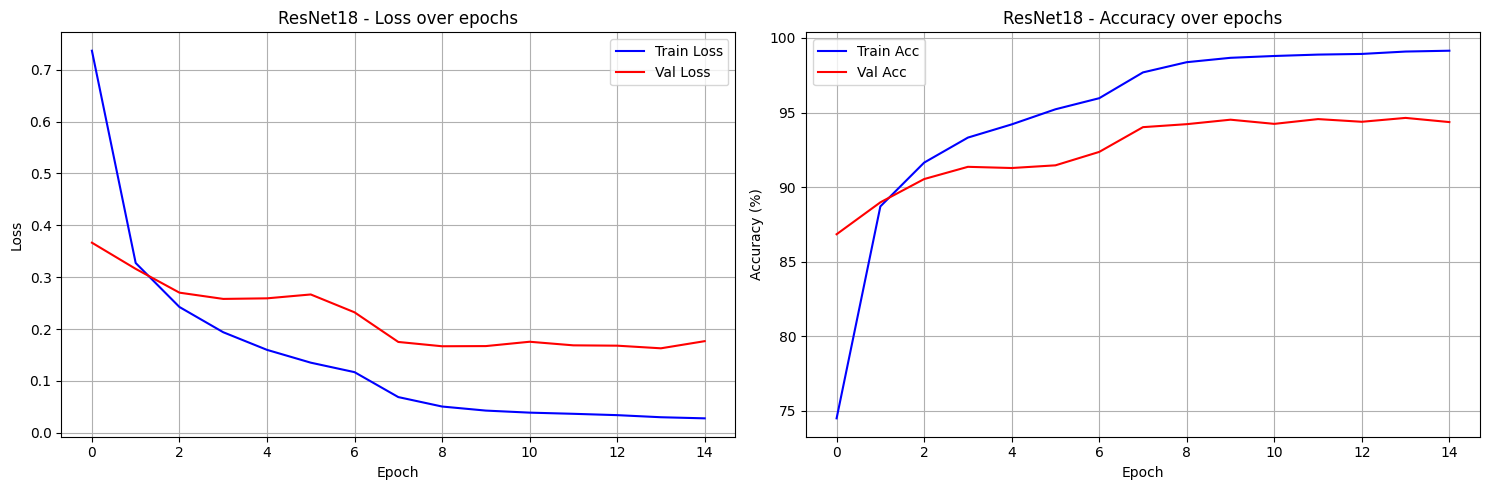

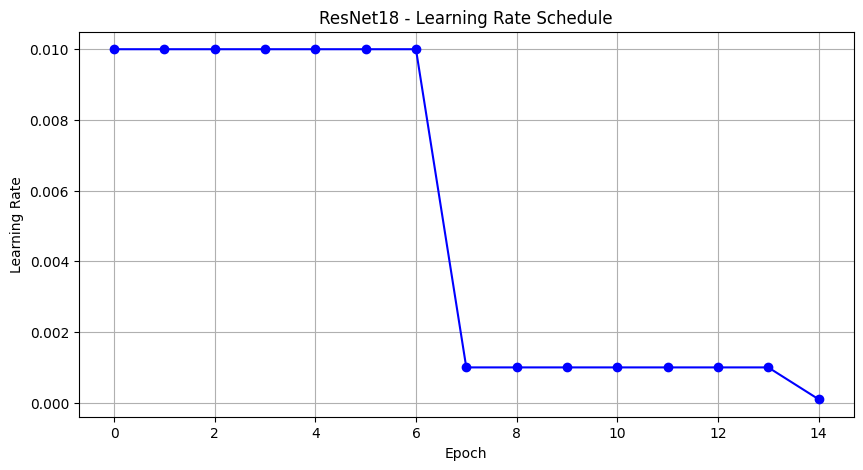

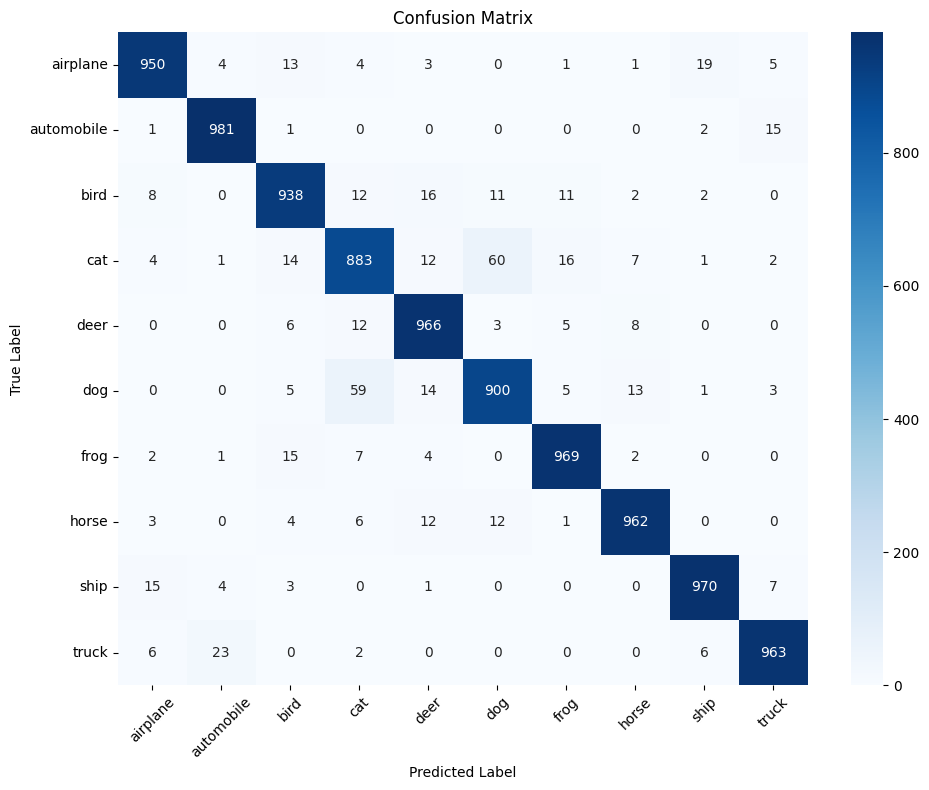

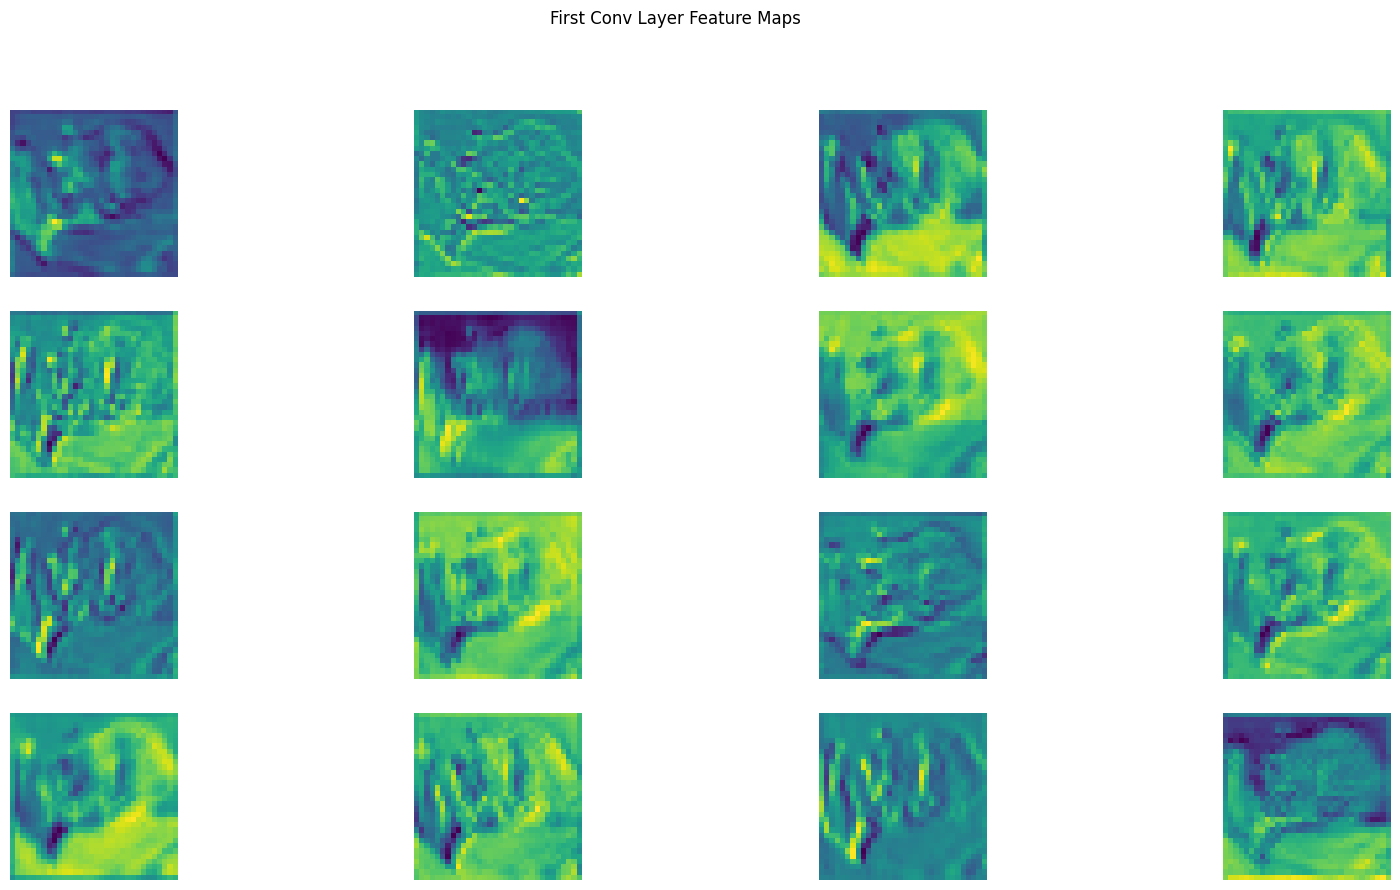


Training ResNet34...
Epoch 1/15
--------------------
Train Loss: 0.7635 Train Acc: 73.72%
Val Loss: 0.4213 Val Acc: 85.72%
Epoch 2/15
--------------------
Train Loss: 0.3165 Train Acc: 89.15%
Val Loss: 0.3042 Val Acc: 88.74%
Epoch 3/15
--------------------
Train Loss: 0.2254 Train Acc: 92.32%
Val Loss: 0.2499 Val Acc: 91.28%
Epoch 4/15
--------------------
Train Loss: 0.1681 Train Acc: 94.19%
Val Loss: 0.2535 Val Acc: 91.54%
Epoch 5/15
--------------------
Train Loss: 0.1426 Train Acc: 95.15%
Val Loss: 0.2045 Val Acc: 92.80%
Epoch 6/15
--------------------
Train Loss: 0.1194 Train Acc: 95.82%
Val Loss: 0.2126 Val Acc: 92.80%
Epoch 7/15
--------------------
Train Loss: 0.0989 Train Acc: 96.58%
Val Loss: 0.2165 Val Acc: 92.78%
Epoch 8/15
--------------------
Train Loss: 0.0523 Train Acc: 98.24%
Val Loss: 0.1509 Val Acc: 94.78%
Epoch 9/15
--------------------
Train Loss: 0.0374 Train Acc: 98.76%
Val Loss: 0.1542 Val Acc: 95.22%
Epoch 10/15
--------------------
Train Loss: 0.0309 Train Ac

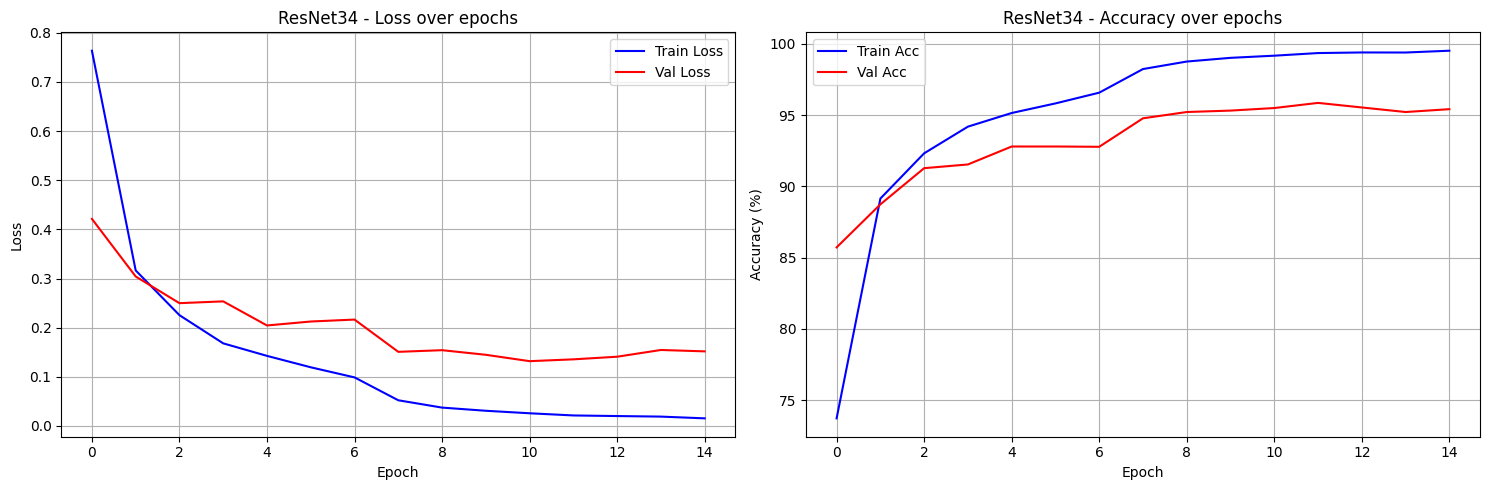

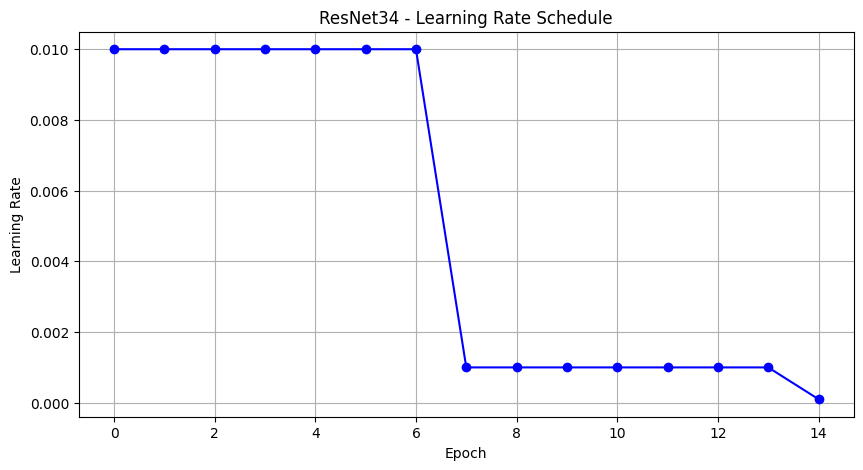

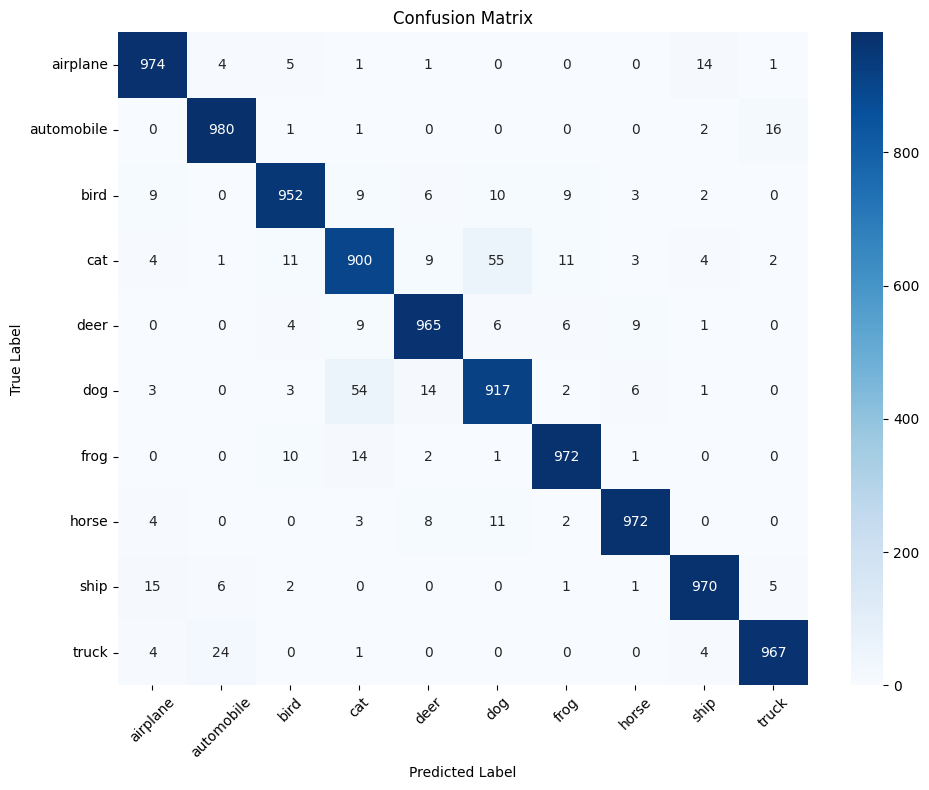

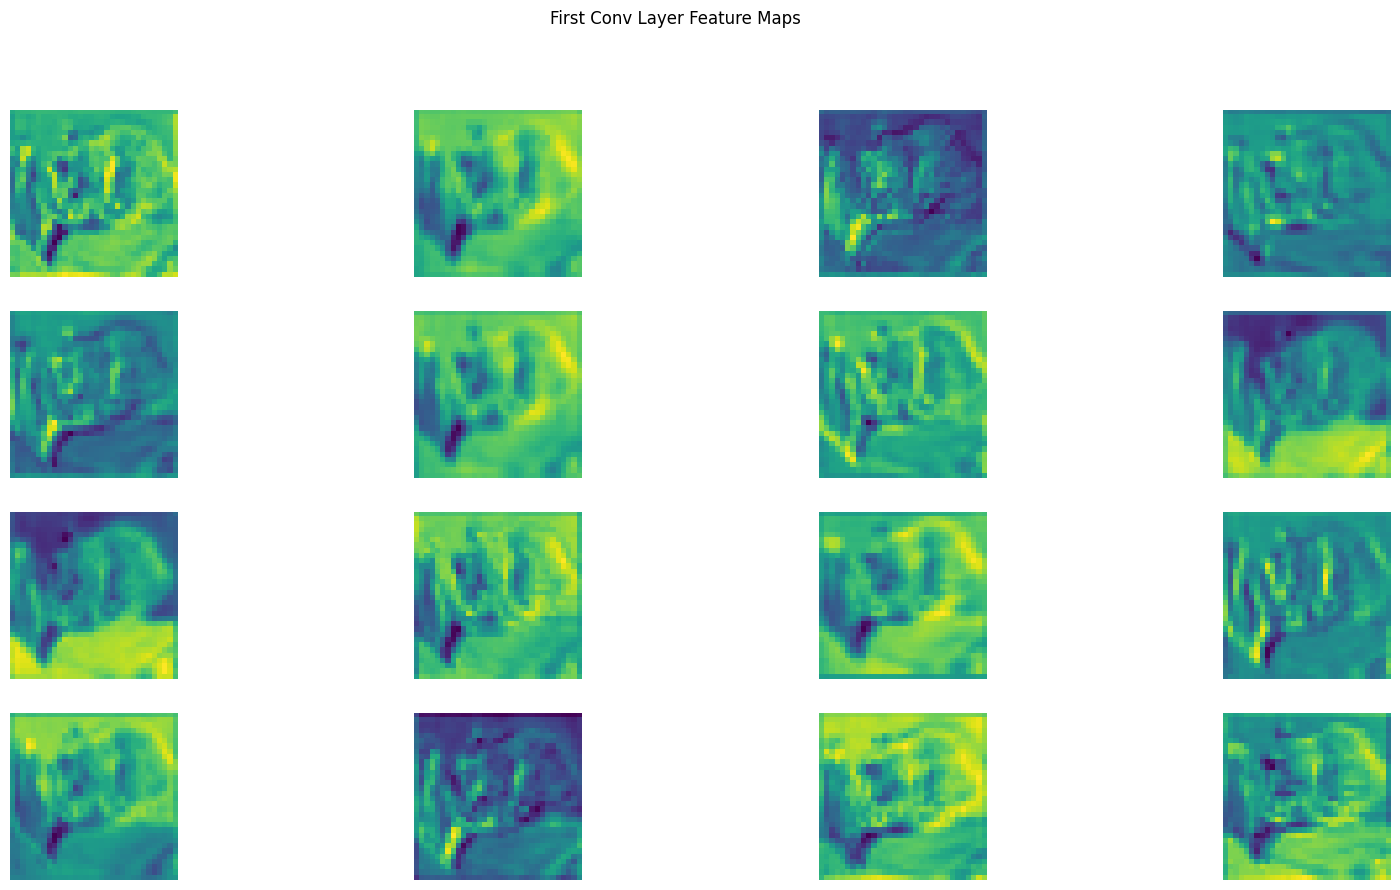


Training VGG16...
Epoch 1/15
--------------------
Train Loss: 0.9920 Train Acc: 66.44%
Val Loss: 0.6586 Val Acc: 77.80%
Epoch 2/15
--------------------
Train Loss: 0.5946 Train Acc: 81.05%
Val Loss: 0.4691 Val Acc: 83.60%
Epoch 3/15
--------------------
Train Loss: 0.4689 Train Acc: 84.90%
Val Loss: 0.4635 Val Acc: 83.64%
Epoch 4/15
--------------------
Train Loss: 0.4043 Train Acc: 87.04%
Val Loss: 0.4486 Val Acc: 84.82%
Epoch 5/15
--------------------
Train Loss: 0.3582 Train Acc: 88.41%
Val Loss: 0.4116 Val Acc: 86.00%
Epoch 6/15
--------------------
Train Loss: 0.3277 Train Acc: 89.42%
Val Loss: 0.4439 Val Acc: 85.14%
Epoch 7/15
--------------------
Train Loss: 0.3040 Train Acc: 90.17%
Val Loss: 0.3329 Val Acc: 89.00%
Epoch 8/15
--------------------
Train Loss: 0.1892 Train Acc: 93.84%
Val Loss: 0.2865 Val Acc: 90.54%
Epoch 9/15
--------------------
Train Loss: 0.1642 Train Acc: 94.56%
Val Loss: 0.2797 Val Acc: 90.96%
Epoch 10/15
--------------------
Train Loss: 0.1563 Train Acc: 

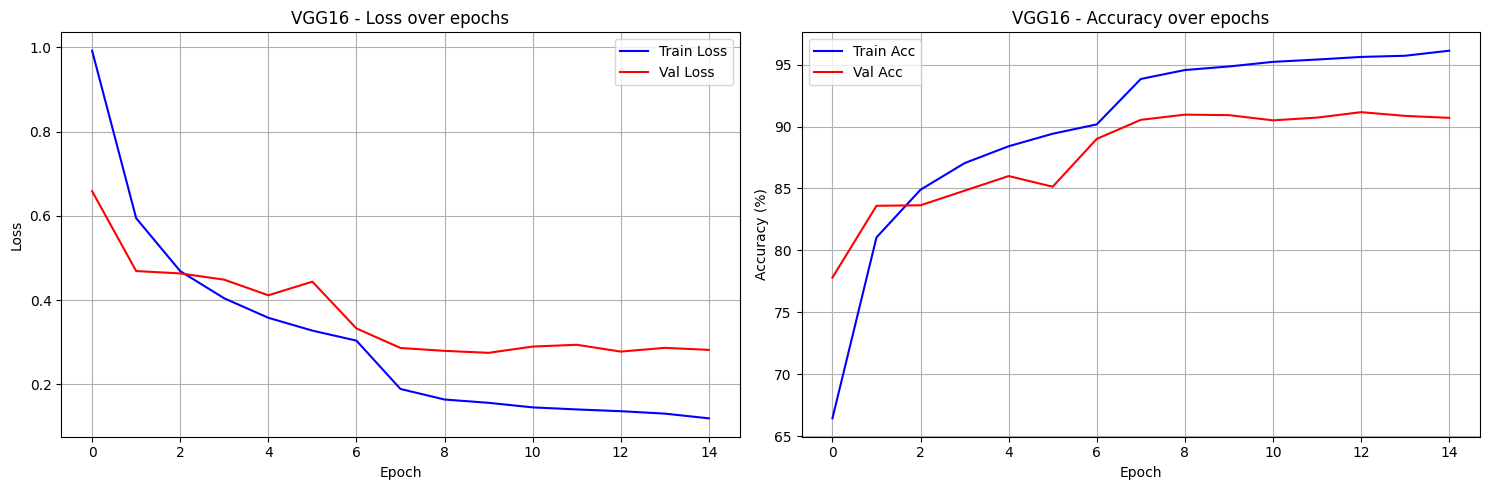

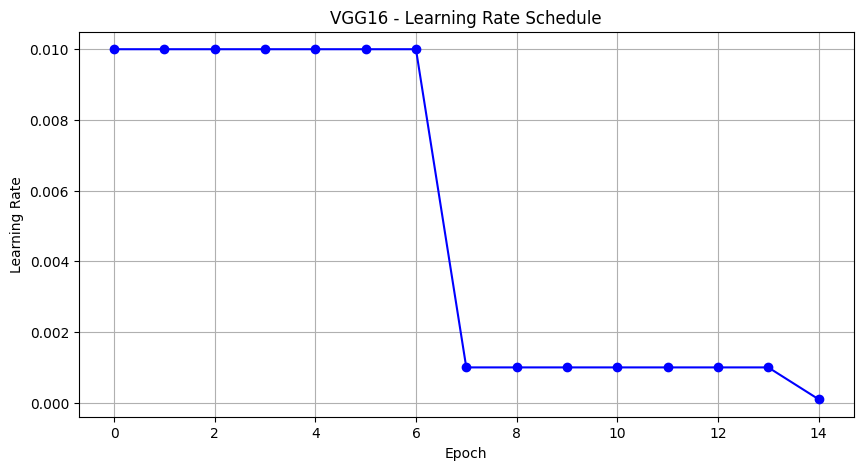

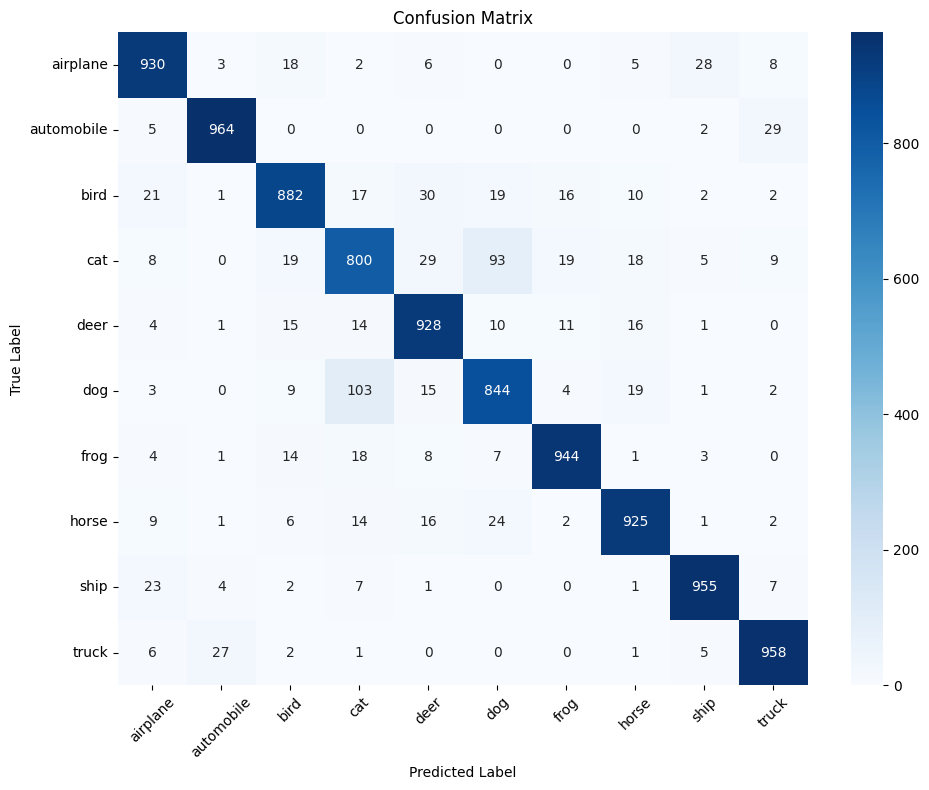

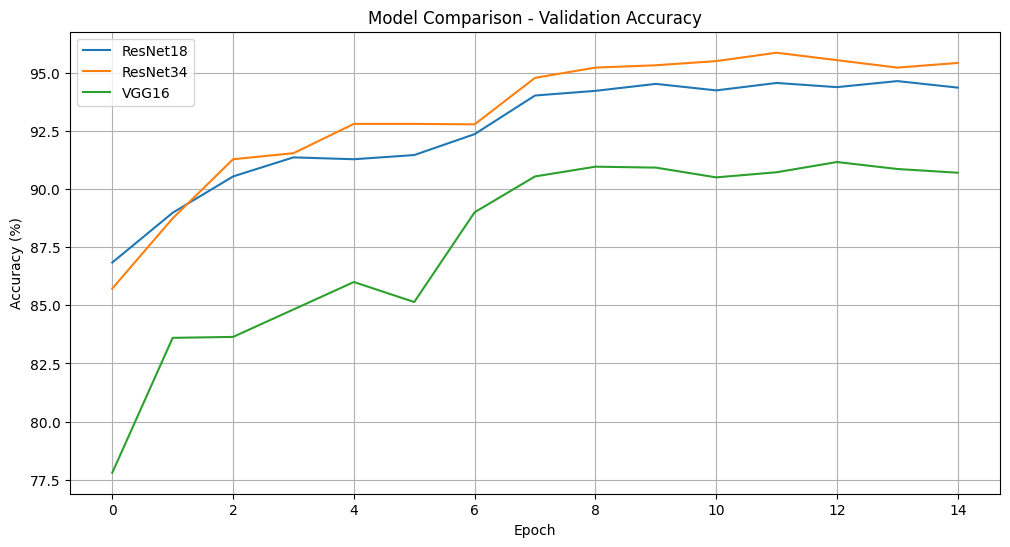

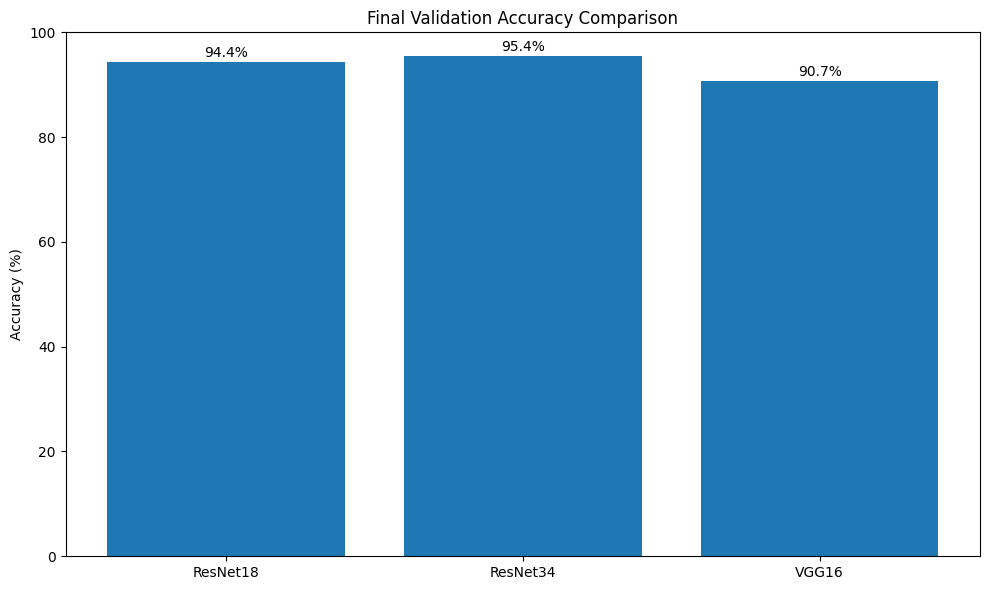


Final Test Accuracies:
------------------------------
ResNet18: 94.82%
ResNet34: 95.69%
VGG16: 91.30%


In [6]:
# Main training loop
def main():
    # Prepare data
    train_loader, val_loader, test_loader = prepare_data()
    
    # Show some training images
    show_train_images(train_loader)
    
    # CIFAR-10 class names
    class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                  'dog', 'frog', 'horse', 'ship', 'truck']
    
    # Models to train
    models_to_train = {
        'ResNet18': MyResNet18(),
        'ResNet34': MyResNet34(),
        'VGG16': MyVGG16()
    }
    
    # Results dictionary
    all_results = {}
    
    # Train each model
    for model_name, model in models_to_train.items():
        print(f"\nTraining {model_name}...")
        
        # Train model
        trained_model, train_losses, val_losses, train_accs, val_accs, learning_rates = train_my_model(
            model, train_loader, val_loader
        )
        
        # Save results
        all_results[model_name] = {
            'model': trained_model,
            'train_losses': train_losses,
            'val_losses': val_losses,
            'train_accs': train_accs,
            'val_accs': val_accs,
            'learning_rates': learning_rates
        }
        
        # Show training plots
        show_training_plots(train_losses, val_losses, train_accs, val_accs, model_name)
        
        # Show learning rate schedule
        plot_learning_rate(learning_rates, model_name)
        
        # Show confusion matrix
        plot_confusion_matrix(trained_model, test_loader, class_names)
        
        # Show feature maps
        plot_feature_maps(trained_model, test_loader)
        
        # Save model
        torch.save(trained_model.state_dict(), f'{model_name}_cifar10_model.pth')
    
        # Compare models
    plt.figure(figsize=(12, 6))
    for model_name, results in all_results.items():
        plt.plot(results['val_accs'], label=f'{model_name}')
    
    plt.title('Model Comparison - Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Bar plot of final accuracies
    final_accuracies = {}
    plt.figure(figsize=(10, 6))
    
    for model_name, results in all_results.items():
        # Get final validation accuracy
        final_acc = results['val_accs'][-1]
        final_accuracies[model_name] = final_acc
    
    # Create bar plot
    plt.bar(final_accuracies.keys(), final_accuracies.values())
    plt.title('Final Validation Accuracy Comparison')
    plt.ylabel('Accuracy (%)')
    plt.ylim(0, 100)  # Set y-axis from 0 to 100
    
    # Add value labels on top of each bar
    for i, (model, acc) in enumerate(final_accuracies.items()):
        plt.text(i, acc + 1, f'{acc:.1f}%', ha='center')
    
    plt.tight_layout()
    plt.show()

    # Print final test accuracies
    print("\nFinal Test Accuracies:")
    print("-" * 30)
    for model_name, results in all_results.items():
        model = results['model']
        model.eval()
        correct = 0
        total = 0
        
        with torch.no_grad():
            for images, labels in test_loader:
                images = images.to(my_device)
                labels = labels.to(my_device)
                outputs = model(images)
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
        
        test_acc = 100 * correct / total
        print(f"{model_name}: {test_acc:.2f}%")

if __name__ == "__main__":
    main()